<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab1/Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab1/Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2021 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Music Generation with RNNs
Here, we will explore building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music.

## 1.1 Dependencies
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [ ]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x
import tensorflow as tf

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.6.1-py3-none-any.whl size=2118512 sha256=3bd549df872784032087bb8e980ccff02f14354a7a221080f4504f02e7cba7bd
  Stored in directory: /root/.cache/pip/wheels/a1/67/db/909c55e80ce7fc2a8dbe1bbff0e591a69d12d11136b4cfe34c
Successfully built mitdeeplearning


## 1.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it:


In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


We can easily convert a song in ABC notation to an audio waveform and play it back. Be patient for this conversion to run, it can take some time.

In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

Output hidden; open in https://colab.research.google.com to view.

One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## 1.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information.

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task.

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [ ]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [ ]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''

def vectorize_string(string):
  vectorized_songs = np.array([char2idx[song] for song in string ])
  return vectorized_songs
vectorized_songs = vectorize_string(songs_joined)

We can also look at how the first part of the text is mapped to an integer representation:

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1:i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 30 ('E')
  expected output: 30 ('E')
Step   1
  input: 30 ('E')
  expected output: 14 ('2')
Step   2
  input: 14 ('2')
  expected output: 82 ('|')
Step   3
  input: 82 ('|')
  expected output: 31 ('F')
Step   4
  input: 31 ('F')
  expected output: 26 ('A')


## 1.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.SimpleRNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN): Our SimpleRNN network, with size `units=rnn_units`.
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


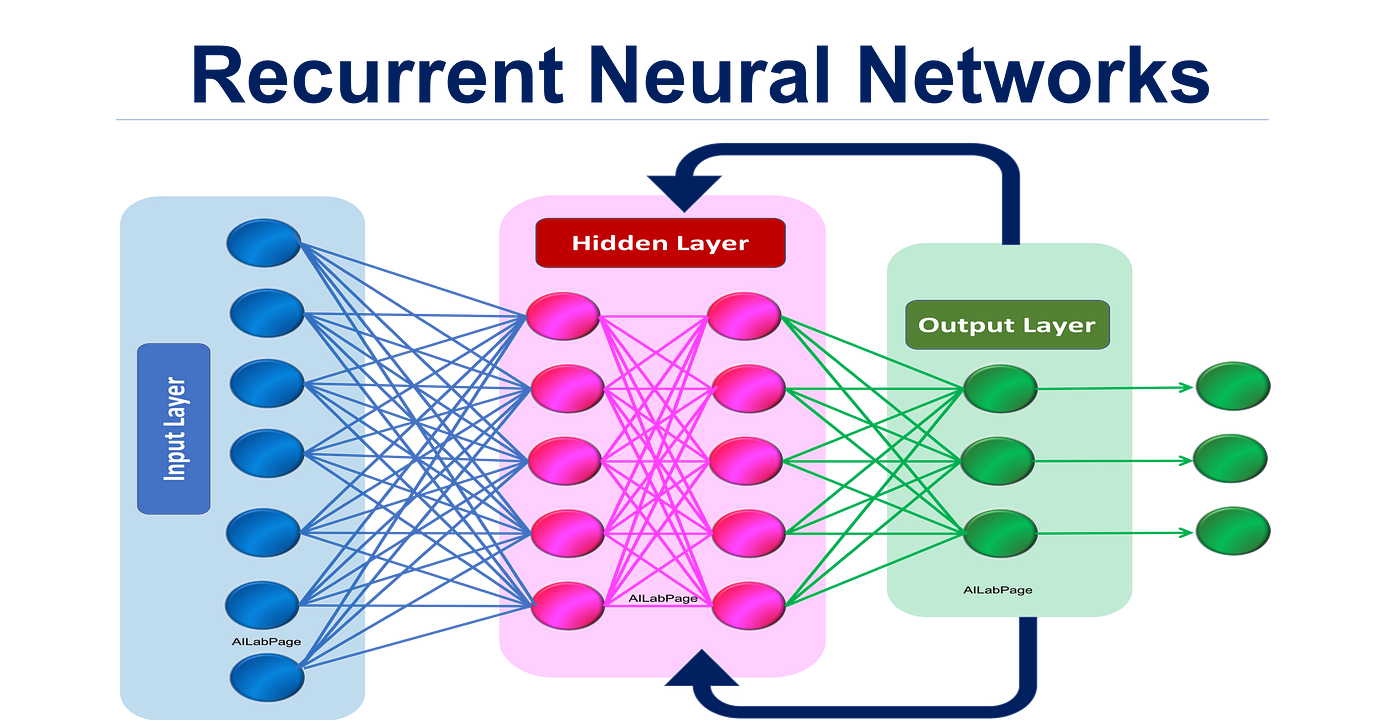

### Define the RNN model

Now, we will define a function that we will use to actually build the model.

In [ ]:
import tensorflow as tf

def SimpleRNN(rnn_units):
    return tf.keras.layers.SimpleRNN(
        rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        activation='tanh'
    )

def build_simple_rnn_model(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.Sequential([
        # Layer 1: Embedding layer to transform indices into dense vectors
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)),

        # Layer 2: Simple RNN with `rnn_units` number of units.
        SimpleRNN(rnn_units),

        # Layer 3: Dense (fully-connected) layer that transforms the RNN output
        #   into the vocabulary size.
        tf.keras.layers.Dense(units=vocab_size)
    ])

    return model

# Build a simple RNN model with default hyperparameters.
model = build_simple_rnn_model(vocab_size=10000, embedding_dim=256, rnn_units=1024)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The time has come! Fill in the `TODOs` to define the RNN model within the `build_model` function, and then call the function you just defined to instantiate the model!

### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 1024)          │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 10000)         │      10,250,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,121,744 (53.87 MB)

 Trainable params: 14,121,744 (53.87 MB)

 Non-trainable params: 0 (0.00 B)

We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [ ]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 10000) # (batch_size, sequence_length, vocab_size)


### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [ ]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([5425, 2715, 4413, 1011, 7900,   87,   83, 4311, 8090, 7287, 3094,
         33, 9465, 1363, 1278, 8869, 6115, 2536, 8114, 8702, 6660, 5723,
       7777,  650, 1625, 9595, 9228,  933, 7170, 2608, 2392, 3939, 1938,
        613,  587, 4634, 9539, 2296, 2646, 8576, 1490, 8559, 2729, 8745,
       5717, 5950, 1255, 2468, 1207, 4638, 2152, 8530, 8386, 5281, 2537,
       1669, 4097, 6713, 7413, 7934, 9844, 2041, 6949, 2736, 3688, 6722,
       4391, 7265, 4567,  194, 1064, 7106, 6963, 7886, 1850, 6949, 9065,
       9647, 4007, 7613, 4821, 8158, 5650, 5140, 8241, 6109, 9458, 1740,
       7633, 9672, 8530,  653, 7087, 7719, 3642, 9391, 8790, 2578, 5719,
       9227])

We can now decode these to see the text predicted by the untrained model:

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
# Ensure indices are within the valid range for idx2char
valid_indices = [idx % len(idx2char) for idx in sampled_indices]
print("Next Char Predictions: \n", repr("".join(idx2char[valid_indices])))

Input: 
 'g|fef dBA|Bee e2d|Bee e3|!\nfga efg|fef dBA|Bdd d2A|Bdd d2:|!\ne|fdd edd|f3 edA|Bee e2d|Bee e3|!\nfdd e'

Next Char Predictions: 
 'Ed233#\nwNk<H"JHpaUho8xcnWY38GJmMDG(nv_rBx.rErb.fTrvi"[V-ErAXYXeyK|tS!CmZs =e67<e)=(v=YxyySiqG\nr0t\'t2'


## 1.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character.

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model:

In [ ]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

'''TODO: compute the loss using the true next characters from the example batch
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) # TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 10000)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       9.214755


Let's start by defining some hyperparameters for training the model. To start, we have provided some reasonable values for some of the parameters. It is up to you to use what we've learned in class to help optimize the parameter selection here!

In [ ]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) and [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

First, we will instantiate a new model and an optimizer. Then, we will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations.

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

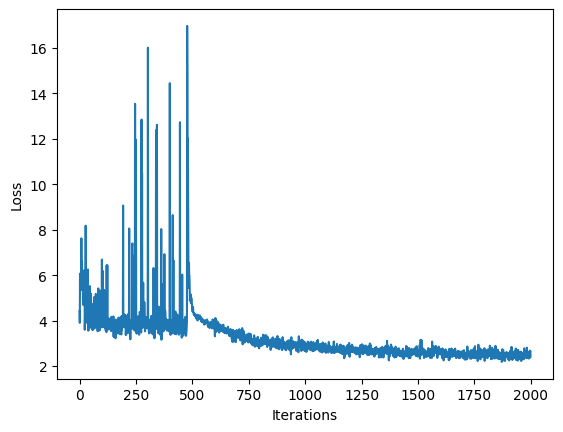

100%|██████████| 2000/2000 [36:54<00:00,  1.11s/it]


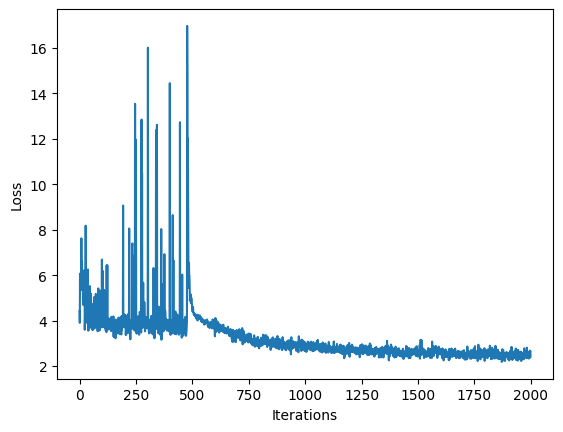

In [ ]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
# Instantiate the model
model = build_simple_rnn_model(vocab_size, embedding_dim, rnn_units)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y):
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients
  '''TODO: complete the function call for gradient computation.
      Remember that we want the gradient of the loss with respect all
      of the model parameters.
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# Create the checkpoint directory if it doesn't exist
import os
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)
 # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix + '.weights.h5') # Add the '.weights.h5' extension to the filename

# Save the trained model and the weights
model.save_weights(checkpoint_prefix + '.weights.h5') # Add the '.weights.h5' extension to the filename

## 1.6 Evaluation of Model

**Now we will calculate the accuracy of the model**

In [ ]:
# Assuming 'pred' is the output of your model
# Make sure to execute the model to get predictions before this step
pred = model(x)

sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

# Clip the sampled indices to be within the valid vocabulary range
sampled_indices = [index if index < len(idx2char) else len(idx2char)-1 for index in sampled_indices]

sampled_chars = [idx2char[index] for index in sampled_indices]
print("Input: \n", repr("".join([idx2char[index] for index in x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(sampled_chars)))

def compute_accuracy(labels, logits):
  labels = tf.cast(labels, tf.int64)
  predictions = tf.argmax(logits, axis=2)
  accuracy = tf.equal(predictions, labels)
  accuracy = tf.cast(accuracy, tf.float32)
  return tf.reduce_mean(accuracy)

accuracy = compute_accuracy(y, pred) # Assuming 'y' is the ground truth
print("Accuracy: ", accuracy.numpy())

Input: 
 'g|fef dBA|Bee e2d|Bee e3|!\nfga efg|fef dBA|Bdd d2A|Bdd d2:|!\ne|fdd edd|f3 edA|Bee e2d|Bee e3|!\nfdd e'

Next Char Predictions: 
 'egdd2FeBBe2g^ade !Afdegag\n(ecegegefaceeBDFcAd a2Nd!aA gaad!\ngf!ef|tAegad|Fae|!B2 ee2gfdgegadf\nde |ad'
Accuracy:  0.2334375


**Calculate Note Accuracy, Chord Accuracy and Perplexity**

In [ ]:
import tensorflow as tf
import numpy as np

# Chord Accuracy (assuming chords are represented by multiple consecutive notes)
def compute_chord_accuracy(labels, logits, chord_length=3):
  labels = tf.cast(labels, tf.int64)
  predictions = tf.argmax(logits, axis=2)

  num_correct_chords = 0
  num_total_chords = 0

  for i in range(0, labels.shape[1] - chord_length + 1):
    true_chord = labels[0, i: i + chord_length]
    pred_chord = predictions[0, i: i + chord_length]
    if tf.reduce_all(tf.equal(true_chord % 12, pred_chord % 12)):
      num_correct_chords += 1
    num_total_chords += 1

  if num_total_chords == 0:
    return 0.0
  else:
    return num_correct_chords / num_total_chords

def evaluate_accuracy(model, dataset, batch_size):
    """Evaluate the accuracy of the model on the given dataset."""
    accuracies = []

    for x_batch, y_batch in dataset:
        # Make predictions
        y_pred = model(x_batch, training=False)

        # Calculate accuracy for the batch
        accuracy = compute_accuracy(y_batch, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    print(f"Accuracy: {mean_accuracy:.4f}")

    return mean_accuracy

def calculate_perplexity(y_true, y_pred):
    """Calculate perplexity."""
    loss = compute_loss(y_true, y_pred)
    perplexity = tf.exp(tf.reduce_mean(loss))
    return perplexity.numpy()

def evaluate_model(model, dataset):
    """Evaluate the model on the given dataset."""
    total_loss = 0.0
    total_accuracy = 0.0
    total_perplexity = 0.0
    num_batches = 0

    for x_batch, y_batch in dataset:
        # Make predictions
        y_pred = model(x_batch, training=False)

        # Calculate metrics
        chord_accuracy = compute_loss(y_batch, y_pred)
        accuracy = compute_accuracy(y_batch, y_pred)
        perplexity = calculate_perplexity(y_batch, y_pred)

        # Accumulate metrics
        total_loss += tf.reduce_mean(loss).numpy()
        total_accuracy += accuracy
        total_perplexity += perplexity
        num_batches += 1

    # Calculate averages
    #avg_loss = total_loss / num_batches
    chord_accuracy = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_perplexity = total_perplexity / num_batches

    print("Chord Accuracy: ", chord_accuracy)
    print(f"Note Accuracy: {avg_accuracy:.4f}")
    print(f"Perplexity: {avg_perplexity:.4f}")

    return avg_accuracy, avg_perplexity

# Generate a dataset for evaluation
x_val, y_val = get_batch(vectorized_songs, seq_length=100, batch_size=32)

# Wrap the evaluation data in a dataset
val_dataset = [(x_val, y_val)]

# Evaluate the model
avg_accuracy, avg_perplexity = evaluate_model(model, val_dataset)


Chord Accuracy:  2.6394107341766357
Note Accuracy: 0.2503
Perplexity: 14.9681


## 1.7 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built.

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [ ]:
class SimpleRNNModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   recurrent_initializer='glorot_uniform',
                                   stateful=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, batch_size=1):
    x = self.embedding(inputs)
    x = self.gru(x)
    return self.dense(x)

Notice that we have fed in a fixed `batch_size` of 1 for inference.

### The Prediction Procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

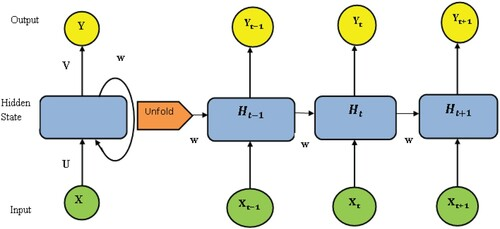

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[num] for num in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)

      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)

      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=30000) # TODO


100%|██████████| 30000/30000 [08:52<00:00, 56.31it/s]


### Play back the generated music!

We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough, or re-generating the song!

In [ ]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)
for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  mdl.lab1.play_song(song)
  print(song, end="\n\n\n\n")
  #print(song)

Found 383 songs in text
X:8
M:8
A|cBAGABcc-por
Mjor
EF2:dcdB2B2:d2:D e Bcd Bc3 Bcelalgfgf222:1/8
Magg g|E (3|!



z|g gag|G|d2:8




B|Bc-r
E2 AGFA2ec22ecd fecB2:Psedcd|f|!
(3:8
M:AFAB2 ABc-popol-r
K:8/8
K:C/8
cAB2:Rafec gagff|!
cdcAFA2:d|cABGB2e|!
B|fed|!



B|Bc-r
E2 AGFA2ec22ecd fecB2:Psedcd|f|!
(3:8
M:AFAB2 ABc-popol-r
K:8/8
K:C/8
cAB2:Rafec gagff|!
cdcAFA2:d|cABGB2e|!
B|fed|!



Mag ecA2:C
Mre|!
Z8
K:33222e Maajiag|c|agaganeg cBB2eed|EFG2:6/8
K:|BFAD:D2:2:338
M:8
K:|df|(322:2:dB2edccA gef cd2:d|AG|AB2:8
K:1/8
X:|B2e^cd cAF22:1/8
(3g|!
Magec A,E eggg B2:d|cdB Mr
Mage|ate|BA2c2:dc-1/8
T1/8
AF|fan
K:GBGABAABGB22:d eg|!



K:|GBGFA2:dcAB2:|!
EG2e (32:1/8
A23|de|!
[2|c|!



EEDE2 AGFGB2:32:|!
c/8
d:dc|!
Mhefed2 c2:d E AGFFDFD2:3 c|BcA cAG2 e|!
Magg|cB2:8
T8



K:|d:/8
K:8
Mjig|!
Mjor




K:d Msedc cAA2: atedc|g|B2:C
X:1/8
M8
L:|!
X: eg-hoaaafd|cBAGB2:58



K:d Msedc cAA2: atedc|g|B2:C
X:1/8
M8
L:|!
X: eg-hoaaafd|cBAGB2:58



cA2ecd/893|A2:|d|B2:d|!
AB2edeecABAc|BGFG2egag ED Bded Mjor
M

## 1.8 Model evaluation after execution using Accuracy_score, Precision_score, Recall_score, F1_score

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf

def compute_metrics(y_true, y_pred):
    """Computes accuracy, precision, recall, and F1-score.

    Args:
        y_true: Ground truth labels (one-hot encoded).
        y_pred: Predicted labels (logits or probabilities).

    Returns:
        A dictionary containing the metrics.
    """
    # Convert one-hot encoded labels to class indices
    y_true_classes = np.argmax(y_true, axis=-1)

    # Convert predicted probabilities or logits to class indices
    y_pred_classes = np.argmax(y_pred, axis=-1)

    # Flatten arrays for metric computation
    y_true_classes = y_true_classes.flatten()
    y_pred_classes = y_pred_classes.flatten()

    # Compute metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
    recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def evaluate_rnn_model(model, x_test, y_test):
    """Evaluates the RNN model on test data and prints the metrics.

    Args:
        model: Trained RNN model.
        x_test: Test input data.
        y_test: Ground truth labels for the test data (one-hot encoded).
    """
    # Predict using the trained model
    y_pred = model.predict(x_test) # Use x_test instead of x_batch

    # Ensure y_test and y_pred have the same number of samples
    assert y_test.shape[0] == y_pred.shape[0], "Mismatch in the number of samples between true labels and predictions."

    # Compute the metrics
    metrics = compute_metrics(y_test, y_pred) # Use y_test instead of y_batch
    print(metrics)

    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Replace 'model' with your actual trained model
# Generate x_test and y_test with the correct vocabulary size
x_test = np.random.randint(0, 83, size=(32, 20))  # 32 samples, each with a sequence length of 20
y_test = tf.keras.utils.to_categorical(np.random.randint(0, 83, size=(32, 20)), num_classes=83)  # One-hot encoded true labels

# Evaluate the model with properly formatted input data
evaluate_rnn_model(model, x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
{'accuracy': 0.0171875, 'precision': 0.558931947805358, 'recall': 0.015653523183643665, 'f1_score': 0.3675621554543248}
accuracy: 0.0172
precision: 0.5589
recall: 0.0157
f1_score: 0.3676


## 1.9 Conversion to mp3

In [ ]:
!pip install pydub
!apt-get install ffmpeg -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from pydub import AudioSegment
from pydub.generators import Sine
import os

def text_to_waveform(song_text, duration_ms=500):
    """Convert song text to a waveform."""
    frequencies = {
        'C': 261.63,
        'D': 293.66,
        'E': 329.63,
        'F': 349.23,
        'G': 392.00,
        'A': 440.00,
        'B': 493.88,
    }
    waveform = AudioSegment.silent(duration=0)

    for char in song_text:
        if char in frequencies:
            sine_wave = Sine(frequencies[char]).to_audio_segment(duration=duration_ms)
            waveform += sine_wave

    return waveform

# Initialize an empty AudioSegment for the combined song
combined_song = AudioSegment.silent(duration=0)

# Convert each generated song and append it to the combined_song
for i, song_text in enumerate(generated_songs):
    waveform = text_to_waveform(song_text)
    combined_song += waveform  # Append the waveform to the combined song

# Define the output path for the combined MP3 file
output_path = "combined_generated_song.mp3"

# Export the combined waveform as an MP3 file
combined_song.export(output_path, format="mp3")

print(f"Saved the combined generated song as {output_path}")


Saved the combined generated song as combined_generated_song.mp3


In [ ]:
from IPython.display import Audio

# Load and display the combined MP3 file
Audio("combined_generated_song.mp3")


## Experiment and **get awarded for the best songs**!

Congrats on making your first sequence model in TensorFlow! It's a pretty big accomplishment, and hopefully you have some sweet tunes to show for it.

Consider how you may improve your model and what seems to be most important in terms of performance. Here are some ideas to get you started:

*  How does the number of training epochs affect the performance?
*  What if you alter or augment the dataset?
*  Does the choice of start string significantly affect the result?

Try to optimize your model and submit your best song! **MIT students and affiliates will be eligible for prizes during the IAP offering**. To enter the competition, MIT students and affiliates should upload the following to the course Canvas:

* a recording of your song;
* iPython notebook with the code you used to generate the song;
* a description and/or diagram of the architecture and hyperparameters you used -- if there are any additional or interesting modifications you made to the template code, please include these in your description.

You can also tweet us at [@MITDeepLearning](https://twitter.com/MITDeepLearning) a copy of the song! See this example song generated by a previous 6.S191 student (credit Ana Heart): <a href="https://twitter.com/AnaWhatever16/status/1263092914680410112?s=20">song from May 20, 2020.</a>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Have fun and happy listening!

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)